In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F943170EA50>, 5)

It's a pair, consisting of a 28x28px image and a label. The image is an object of the class `PIL.Image.Image`, which is a part of the Python imaging library [Pillow](https://pillow.readthedocs.io/en/stable/). We can view the image within Jupyter using [`matplotlib`](https://matplotlib.org/), the de-facto plotting and graphing library for data science in Python.


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


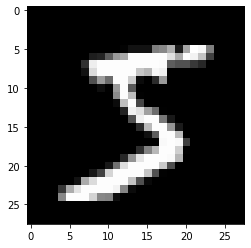

In [7]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


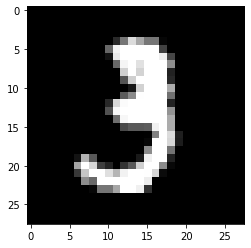

In [8]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

It's evident that these images are relatively small in size, and recognizing the digits can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [9]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The `torchvision.transforms` module contains many such predefined functions. We'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [10]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [11]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB). 

Let's look at some sample values inside the tensor.

In [12]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


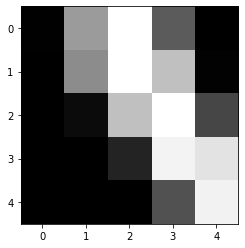

In [13]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [14]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [15]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is _flattened_ into a vector of size 784 `(28*28)` before being passed into the model. 

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [16]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [17]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0259, -0.0089, -0.0100,  ..., -0.0133,  0.0161,  0.0332],
        [ 0.0156, -0.0017, -0.0054,  ..., -0.0125, -0.0181,  0.0039],
        [-0.0081,  0.0020,  0.0184,  ...,  0.0182,  0.0261, -0.0114],
        ...,
        [-0.0049,  0.0118,  0.0308,  ..., -0.0062,  0.0145,  0.0330],
        [-0.0112,  0.0142,  0.0185,  ...,  0.0039, -0.0280,  0.0291],
        [ 0.0310, -0.0339,  0.0086,  ..., -0.0098, -0.0209,  0.0111]],
       requires_grad=True)

In [18]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0209,  0.0048,  0.0122,  0.0034, -0.0344,  0.0335,  0.0111, -0.0066,
         0.0167,  0.0098], requires_grad=True)

In [22]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([4, 2, 1, 3, 5, 5, 1, 9, 4, 1, 2, 5, 9, 3, 1, 4, 7, 2, 8, 7, 7, 4, 3, 9,
        2, 5, 3, 6, 2, 6, 2, 0, 6, 5, 9, 1, 6, 1, 6, 6, 9, 7, 7, 4, 9, 1, 8, 1,
        1, 4, 5, 2, 5, 1, 3, 8, 5, 3, 3, 4, 7, 3, 2, 0, 1, 6, 1, 7, 2, 1, 3, 1,
        3, 3, 8, 0, 2, 0, 7, 7, 0, 1, 7, 0, 8, 3, 6, 9, 8, 3, 4, 3, 4, 1, 0, 4,
        5, 0, 7, 9, 2, 7, 2, 7, 0, 0, 4, 1, 6, 6, 6, 5, 5, 9, 1, 7, 1, 9, 1, 6,
        7, 8, 2, 8, 2, 9, 9, 1])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

In [23]:
images.shape
images.reshape(128, 784).shape

torch.Size([128, 784])

You can learn more about Python classes here: https://www.w3schools.com/python/python_classes.asp .

Classes can also build upon or _extend_ the functionality of existing classes. Let's extend the `nn.Module` class from PyTorch to define a custom model.

In [24]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into `self.linear`.

`xb.reshape(-1, 28*28)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions. The length along the 2nd dimension is 28\*28 (i.e., 784). One argument to `.reshape` can be set to `-1` (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [25]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [26]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0351,  0.0264, -0.0048,  ...,  0.0123,  0.0067,  0.0002],
         [-0.0025, -0.0152, -0.0009,  ...,  0.0058,  0.0306, -0.0039],
         [ 0.0218,  0.0218,  0.0141,  ...,  0.0161, -0.0238, -0.0156],
         ...,
         [ 0.0197,  0.0198, -0.0012,  ...,  0.0146, -0.0336, -0.0094],
         [-0.0102,  0.0230, -0.0218,  ..., -0.0188,  0.0256,  0.0166],
         [ 0.0138, -0.0319, -0.0011,  ...,  0.0341,  0.0203,  0.0339]],
        requires_grad=True), Parameter containing:
 tensor([-0.0279, -0.0331, -0.0023,  0.0241,  0.0147,  0.0324, -0.0310, -0.0152,
         -0.0355, -0.0158], requires_grad=True)]

In [27]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0094, -0.1412,  0.1275, -0.0750,  0.0369,  0.0020, -0.2044,  0.4065,
          0.0450,  0.1030],
        [ 0.0389,  0.0604, -0.0658,  0.1127, -0.0620, -0.0203, -0.3247,  0.1824,
         -0.1516,  0.0391]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case. 

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)

First, we replace each element `yi` in an output row by `e^yi`, making all the elements positive. 

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)



Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [28]:
import torch.nn.functional as F
outputs[:2]

tensor([[ 0.0094, -0.1412,  0.1275, -0.0750,  0.0369,  0.0020, -0.2044,  0.4065,
          0.0450,  0.1030],
        [ 0.0389,  0.0604, -0.0658,  0.1127, -0.0620, -0.0203, -0.3247,  0.1824,
         -0.1516,  0.0391]], grad_fn=<SliceBackward0>)

In [29]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0966, 0.0831, 0.1087, 0.0888, 0.0993, 0.0959, 0.0780, 0.1437, 0.1001,
         0.1061],
        [0.1050, 0.1073, 0.0946, 0.1131, 0.0949, 0.0990, 0.0730, 0.1212, 0.0868,
         0.1050]])
Sum:  1.0


In [30]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([7, 7, 9, 1, 0, 0, 3, 5, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 7, 0, 2, 7,
        9, 9, 8, 9, 5, 7, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 7, 5, 0, 7, 0, 4, 0, 3,
        0, 0, 0, 0, 4, 2, 0, 0, 7, 0, 0, 0, 9, 9, 7, 0, 9, 9, 9, 9, 0, 3, 0, 0,
        7, 7, 7, 8, 9, 7, 8, 0, 9, 5, 8, 5, 0, 7, 1, 0, 7, 9, 0, 1, 7, 0, 0, 1,
        8, 7, 0, 0, 5, 0, 4, 8, 8, 5, 0, 1, 1, 1, 7, 0, 0, 0, 5, 1, 0, 0, 0, 0,
        5, 0, 3, 1, 7, 7, 9, 0])
tensor([0.1437, 0.1212, 0.1177, 0.1315, 0.1326, 0.1503, 0.1217, 0.1316, 0.1252,
        0.1253, 0.1207, 0.1202, 0.1636, 0.1331, 0.1250, 0.1411, 0.1240, 0.1519,
        0.1608, 0.1226, 0.1365, 0.1342, 0.1289, 0.1197, 0.1298, 0.1244, 0.1195,
        0.1228, 0.1216, 0.1091, 0.1368, 0.1633, 0.1387, 0.1318, 0.1220, 0.1156,
        0.1287, 0.1449, 0.1493, 0.1186, 0.1215, 0.1184, 0.1437, 0.1186, 0.1423,
        0.1230, 0.1169, 0.1183, 0.1822, 0.1549, 0.1458, 0.1592, 0.1291, 0.1292,
        0.1338, 0.1505, 0.1172, 0.1365, 0.1495, 0.1387, 0.1175, 0.1309, 0.1213,
       

In [31]:
labels

tensor([4, 9, 4, 2, 9, 5, 6, 7, 6, 5, 8, 9, 0, 8, 9, 0, 8, 5, 2, 8, 1, 5, 2, 1,
        1, 4, 9, 7, 7, 4, 6, 0, 0, 7, 2, 0, 3, 6, 7, 3, 3, 0, 0, 1, 3, 6, 8, 0,
        5, 0, 3, 5, 6, 4, 4, 5, 1, 4, 5, 0, 4, 9, 8, 9, 1, 1, 1, 1, 3, 6, 8, 3,
        4, 6, 1, 2, 1, 7, 9, 3, 5, 7, 2, 2, 5, 2, 4, 0, 4, 8, 5, 8, 5, 4, 8, 7,
        3, 3, 0, 5, 3, 5, 9, 2, 9, 1, 4, 2, 0, 0, 6, 6, 4, 9, 7, 9, 6, 6, 5, 0,
        3, 5, 2, 8, 2, 1, 3, 7])

## Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the **accuracy** of the predictions. 

In [32]:
outputs[:2]

tensor([[ 0.0094, -0.1412,  0.1275, -0.0750,  0.0369,  0.0020, -0.2044,  0.4065,
          0.0450,  0.1030],
        [ 0.0389,  0.0604, -0.0658,  0.1127, -0.0620, -0.0203, -0.3247,  0.1824,
         -0.1516,  0.0391]], grad_fn=<SliceBackward0>)

In [33]:
torch.sum(preds == labels)

tensor(14)

In [34]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [35]:
accuracy(outputs, labels)
probs

tensor([[0.0966, 0.0831, 0.1087,  ..., 0.1437, 0.1001, 0.1061],
        [0.1050, 0.1073, 0.0946,  ..., 0.1212, 0.0868, 0.1050],
        [0.1077, 0.1043, 0.0974,  ..., 0.0949, 0.1034, 0.1177],
        ...,
        [0.1098, 0.0755, 0.1110,  ..., 0.1138, 0.0874, 0.1058],
        [0.0997, 0.0889, 0.0922,  ..., 0.1017, 0.0957, 0.1170],
        [0.1289, 0.0894, 0.1028,  ..., 0.1065, 0.0956, 0.1097]],
       grad_fn=<SoftmaxBackward0>)

In [36]:
outputs

tensor([[ 9.4234e-03, -1.4116e-01,  1.2747e-01,  ...,  4.0646e-01,
          4.4958e-02,  1.0304e-01],
        [ 3.8910e-02,  6.0416e-02, -6.5843e-02,  ...,  1.8245e-01,
         -1.5156e-01,  3.9087e-02],
        [ 7.4448e-02,  4.2621e-02, -2.5810e-02,  ..., -5.1784e-02,
          3.3757e-02,  1.6345e-01],
        ...,
        [ 9.4541e-02, -2.7913e-01,  1.0563e-01,  ...,  1.3099e-01,
         -1.3263e-01,  5.7638e-02],
        [ 1.8140e-02, -9.5529e-02, -5.9293e-02,  ...,  3.8869e-02,
         -2.2715e-02,  1.7815e-01],
        [ 2.2649e-01, -1.4020e-01,  7.5556e-05,  ...,  3.5779e-02,
         -7.2756e-02,  6.4846e-02]], grad_fn=<AddmmBackward0>)

In [37]:
loss_fn = F.cross_entropy

In [38]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3114, grad_fn=<NllLossBackward0>)


## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. 

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.



In [39]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [40]:
l1 = [1, 2, 3, 4, 5]

In [41]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [42]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


Finally, let's redefine the `MnistModel` class to include additional methods `training_step`, `validation_step`, `validation_epoch_end`, and `epoch_end` used by `fit` and `evaluate`.

In [44]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [45]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.292557716369629, 'val_acc': 0.07654272019863129}

The initial accuracy is around 10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for five epochs and look at the results.

In [46]:
history1 = fit(5, 0.001, model, train_loader, val_loader)
history2 = fit(5, 0.001, model, train_loader, val_loader)
history3 = fit(5, 0.001, model, train_loader, val_loader)
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9313, val_acc: 0.6468
Epoch [1], val_loss: 1.6685, val_acc: 0.7364
Epoch [2], val_loss: 1.4720, val_acc: 0.7678
Epoch [3], val_loss: 1.3234, val_acc: 0.7879
Epoch [4], val_loss: 1.2090, val_acc: 0.7986
Epoch [0], val_loss: 1.1189, val_acc: 0.8085
Epoch [1], val_loss: 1.0464, val_acc: 0.8158
Epoch [2], val_loss: 0.9871, val_acc: 0.8214
Epoch [3], val_loss: 0.9375, val_acc: 0.8266
Epoch [4], val_loss: 0.8956, val_acc: 0.8313
Epoch [0], val_loss: 0.8596, val_acc: 0.8355
Epoch [1], val_loss: 0.8283, val_acc: 0.8394
Epoch [2], val_loss: 0.8009, val_acc: 0.8421
Epoch [3], val_loss: 0.7767, val_acc: 0.8448
Epoch [4], val_loss: 0.7551, val_acc: 0.8478
Epoch [0], val_loss: 0.7357, val_acc: 0.8502
Epoch [1], val_loss: 0.7182, val_acc: 0.8525
Epoch [2], val_loss: 0.7023, val_acc: 0.8543
Epoch [3], val_loss: 0.6878, val_acc: 0.8554
Epoch [4], val_loss: 0.6744, val_acc: 0.8569


That's a great result! With just 5 epochs of training, our model has reached an accuracy of over 80% on the validation set,so we tried running more epochs to see the accuracy


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

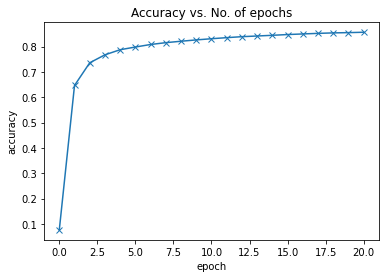

In [47]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [48]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Here's a sample image from the dataset.

Shape: torch.Size([1, 28, 28])
Label: 7


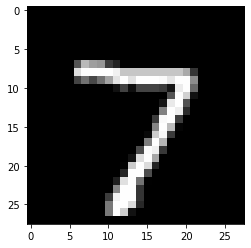

In [49]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [50]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Let's try it out with a few images.

Label: 7 , Predicted: 7


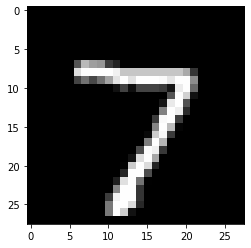

In [51]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


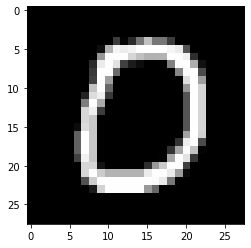

In [52]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 4 , Predicted: 1


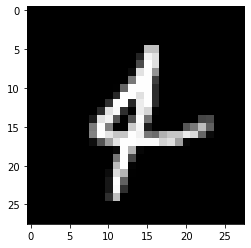

In [53]:
img, label = test_dataset[300]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


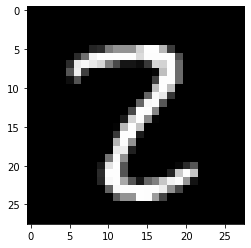

In [54]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [55]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6408393979072571, 'val_acc': 0.8622070550918579}

We expect this to be similar to the accuracy/loss on the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [56]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model.

In [57]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0338, -0.0013, -0.0101,  ...,  0.0248,  0.0324,  0.0054],
                      [-0.0327, -0.0229,  0.0034,  ...,  0.0275, -0.0076,  0.0135],
                      [-0.0222, -0.0152,  0.0247,  ...,  0.0257, -0.0353,  0.0212],
                      ...,
                      [ 0.0327,  0.0183,  0.0232,  ..., -0.0082,  0.0196, -0.0341],
                      [ 0.0012, -0.0133,  0.0152,  ..., -0.0003, -0.0221, -0.0189],
                      [-0.0342,  0.0293, -0.0095,  ..., -0.0113, -0.0113,  0.0060]])),
             ('linear.bias',
              tensor([-0.0494,  0.1054,  0.0073, -0.0278,  0.0506,  0.0620, -0.0375,  0.0263,
                      -0.0685, -0.0246]))])

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict` method.

In [58]:
model2 = MnistModel()

In [59]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0164,  0.0236, -0.0225,  ..., -0.0222,  0.0223, -0.0242],
                      [ 0.0169, -0.0156, -0.0215,  ..., -0.0177, -0.0034,  0.0337],
                      [ 0.0141, -0.0161,  0.0085,  ..., -0.0219,  0.0080, -0.0084],
                      ...,
                      [-0.0328, -0.0161, -0.0093,  ..., -0.0225,  0.0303,  0.0235],
                      [ 0.0287,  0.0206, -0.0212,  ..., -0.0230,  0.0011,  0.0171],
                      [ 0.0005,  0.0041, -0.0250,  ..., -0.0186,  0.0332, -0.0094]])),
             ('linear.bias',
              tensor([-0.0133, -0.0157,  0.0089,  0.0027,  0.0069, -0.0019,  0.0200, -0.0242,
                      -0.0341,  0.0338]))])

In [60]:
evaluate(model2, test_loader)

{'val_loss': 2.2911264896392822, 'val_acc': 0.13632813096046448}

In [61]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0338, -0.0013, -0.0101,  ...,  0.0248,  0.0324,  0.0054],
                      [-0.0327, -0.0229,  0.0034,  ...,  0.0275, -0.0076,  0.0135],
                      [-0.0222, -0.0152,  0.0247,  ...,  0.0257, -0.0353,  0.0212],
                      ...,
                      [ 0.0327,  0.0183,  0.0232,  ..., -0.0082,  0.0196, -0.0341],
                      [ 0.0012, -0.0133,  0.0152,  ..., -0.0003, -0.0221, -0.0189],
                      [-0.0342,  0.0293, -0.0095,  ..., -0.0113, -0.0113,  0.0060]])),
             ('linear.bias',
              tensor([-0.0494,  0.1054,  0.0073, -0.0278,  0.0506,  0.0620, -0.0375,  0.0263,
                      -0.0685, -0.0246]))])

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [62]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6408393979072571, 'val_acc': 0.8622070550918579}